# Continuous Waves Continued

In yesterday's tutorial, we may have touched on one of most important pieces of information we can obtain from an MCMC analysis: the **sky location of the CW source**. If we know where the GW signal came from on the sky, we can then look for host galaxies in that region, or potential electromagnetic signatures of supermassive binaries, in the hopes that we can connect the two in a multi-messenger detection.

Parts of this tutorial are taken from https://rtd.igwn.org/projects/userguide/en/v15/tutorial/skymaps.html

# 0. Package installation & imports
Follow the instructions in the link below to install `ligo.skymap` in your conda environment.

https://lscsoft.docs.ligo.org/ligo.skymap/quickstart/install.html

In [1]:
# imports

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import pickle
import os
import h5py
import csv
from enterprise.pulsar import Pulsar
from enterprise import constants as const
import healpy as hp
import ligo.skymap
import ligo.skymap.plot
import ligo.skymap.io
import corner

In [2]:
# output directory will be the same as this notebook
basedir = './'

# 1. Review: signal localization + tools

How much information does a Bayesian analysis give us about the CW's sky location?

In [3]:
# load example pulsars from yesterday
with open(basedir+'example_dataset.pkl', 'rb') as expkl:
    ex_psrs = pickle.load(expkl)

In [4]:
# load example chain file from yesterday
ex_file = basedir+'example_chain.h5'
with h5py.File(ex_file, 'r') as ff:
    chain = ff['samples_cold'][0,::,:]
    print('Number of samples:', chain.shape)
    par_names = [x.decode('UTF-8') for x in list(ff['par_names'])]
    log_likelihood = ff['log_likelihood'][:,::]

Number of samples: (1000000, 190)


In [5]:
# we need our cos_gwtheta samples and gwphi samples
costheta_samples = chain[:,0]
phi_samples = chain[:,2]
sky_samples = np.stack([costheta_samples,phi_samples], axis=1)

First, let's see how the injected values compare to the signal localization using a corner plot.

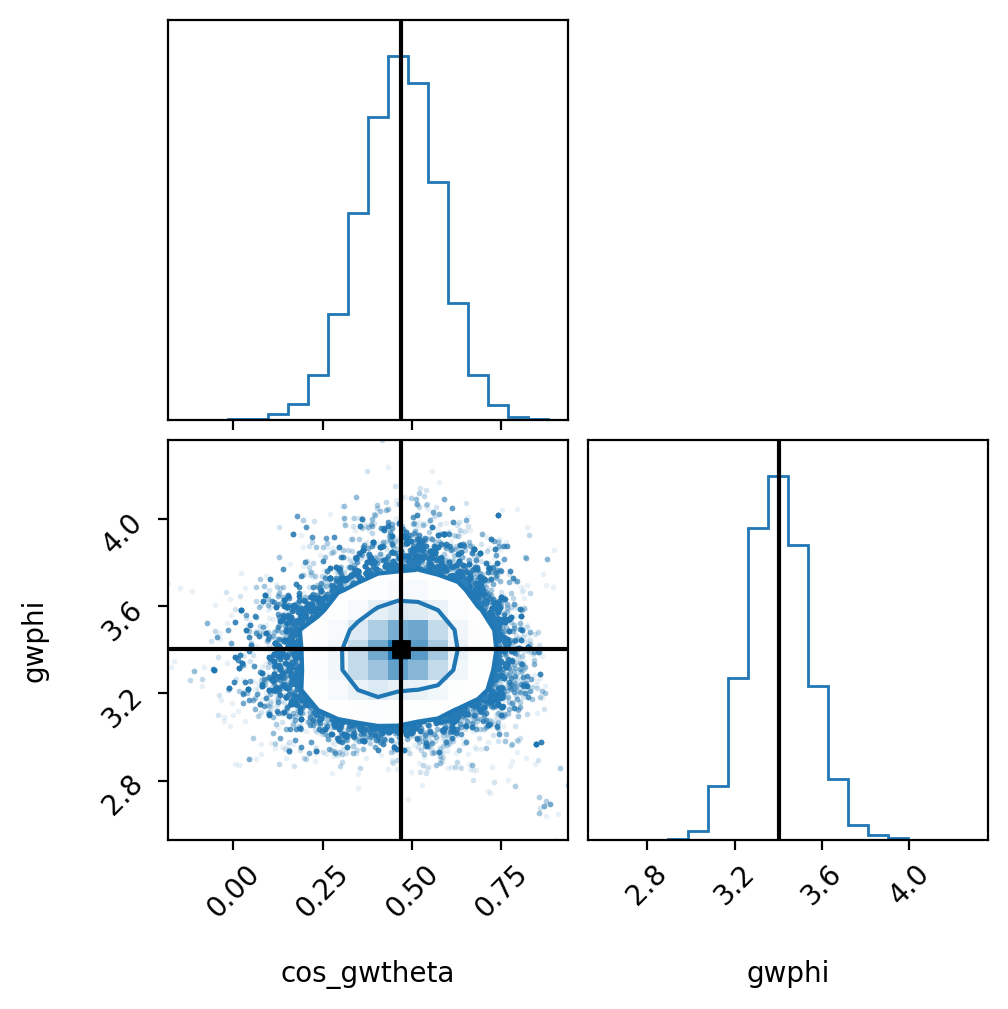

In [6]:
# injected values
ex_ra = (15*(13 + 0/60 + 8.09/3600))
ex_dec = 27 + 58/60 + 37.2/3600
ex_gwphi = ex_ra*np.pi/180
ex_gwtheta = np.pi/2 - ex_dec*np.pi/180

# corner plot
burn = int(len(chain)/4)
corner.corner(sky_samples[burn:,0:2], levels=[0.68,0.95],
              truths=[np.cos(ex_gwtheta),ex_gwphi], truth_color='k', labels=['cos_gwtheta','gwphi'], color='C0')
plt.show()

### Skymap visualization with `healpy`

Looks like the GW signal is recovered fairly well! Now let's see where this region lies on the sky using `healpy`. This software package uses the **H**ierarchical **E**qual **A**rea iso**L**atitude **Pix**elization (HEALPix) scheme, which basically means that it subdivides the sky into pixels that each cover the same surface area. See this link for more info and some nice graphics to illustrate this: https://healpix.jpl.nasa.gov/

First, we need to transform our samples into a HEALPix map, which we'll do using the function below. The function takes in our sky location samples as well as a parameter called $N_{\rm{side}}$, which is the resolution of our skymap. The lowest resolution is $N_{\rm{side}} = 1$, which will split the sky into $12N_{\rm{side}}^2$ equal-area pixels. $N_{\rm{side}}$ values must be a power of 2, i.e., 1, 2, 4, 8, 16, and so on. We'll start with $N_{\rm{side}}=8$, which is a total of 768 pixels.

In [7]:
# function to convert samples into a HEALPix map of number counts

def post2hpx(theta, phi, nside=8):
    
    # converts nside resolution to total number of pixels
    # (this is 768 for nside=8)
    npix = hp.nside2npix(nside) 
    
    # based on a given nside resolution,
    # takes sky samples and assigns a pixel index to each sample
    # (for nside=8 each sample will be assigned a value of 0 through 767 based on where it lies on the sky)
    indices = hp.ang2pix(nside, theta, phi)

    # determine how many samples correspond to each pixel
    # this will give us the density of our samples across the sky
    idx, counts = np.unique(indices, return_counts=True)
    
    # make a blank skymap and then fill it with the counts, or density, of samples
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map

In [8]:
# make the healpy map
hpx_map = post2hpx(np.arccos(costheta_samples), phi_samples, nside=8)

**Take some time to understand what this function is doing.** Print out each step if you need to! When you feel comfortable with the samples-to-skymap conversion, run the cell below to see the skymap. We're plotting using a mollweide (equal-area) projection.

0.0 180.0 -180.0 180.0


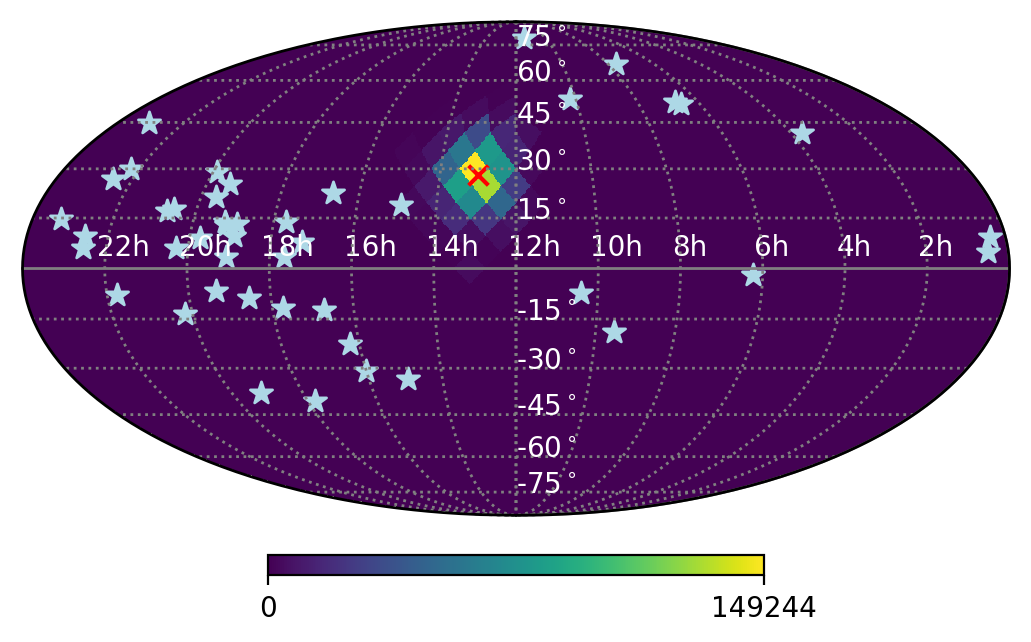

In [9]:
# we're using a mollweide projection map - this is pretty standard
hp.mollview(hpx_map, rot=180, hold=True, title='')

# plot pulsar positions
for i, psr in enumerate(ex_psrs):
    hp.visufunc.projscatter(psr.theta, psr.phi, marker='*', s=70, color='lightblue')

# plot GW source location
hp.visufunc.projscatter(ex_gwtheta, ex_gwphi, marker='x', s=50, color='r')

# plot axis labels by hand (healpy is weird about this)
for i in range(2,24,2):
    text = hp.projtext(i*180/12+3, 4, str(i)+'h', lonlat=True, coord='G', fontsize='medium', zorder=1, color='w')
for i in range(-75,0,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')
for i in range(15,90,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')

# plot grid lines
hp.graticule(15, 30, color='gray')
plt.show()

The colored pixels correspond to our posterior samples, with yellow pixels having more samples. See the colorbar for the number of samples lying in each pixel. **Feel free to play around with the resolution of the map by changing the $N_{\rm{side}}$ value** (with higher $N_{\rm{side}}$ being higher resolution). For reference, we've also plotted this simulated array's pulsars in light blue, and the red X marker is the true injected sky location.

We can also plot the same map but instead with normalized counts, i.e., the percentage of points falling within each pixel.

In [10]:
# healpix map with normalized counts, i.e., percentage of points falling in each pixel
norm_map = hpx_map / np.sum(hpx_map)
print(norm_map)

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.00000e-06 0.00000e+00 1.00000e-06 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 4.00000e-06
 1.00000e-06 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 7.00000e-06
 3.00000e-06 1.00000e-06 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 2.00000e-06 7.00000e-06 4.00000e-06 1.00000e-06 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 3.30000e-05 6.40000e-05 1.77000e-04 8.00000e-06 2.00000e-05 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.80000e-05 0.00000e+00 4.00000e-06 3.84000e-04
 7.54000e-04 4.54000e-04 9.50000e-05 3.00000e-06 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.

0.0 180.0 -180.0 180.0


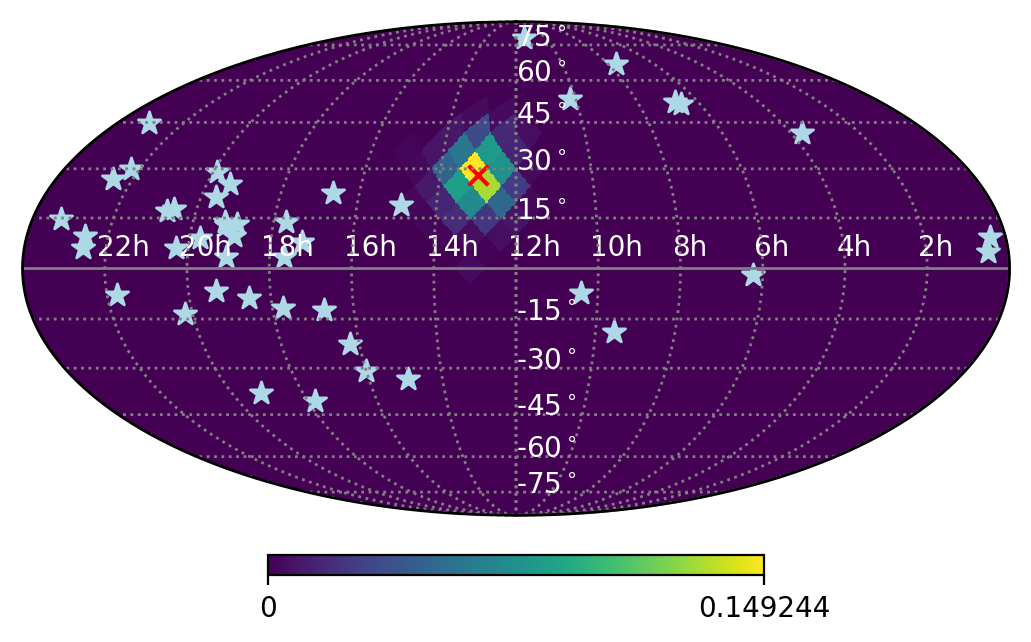

In [11]:
# mollweide projection map
hp.mollview(norm_map, rot=180, hold=True, title='')

# plot pulsar positions
for i, psr in enumerate(ex_psrs):
    hp.visufunc.projscatter(psr.theta, psr.phi, marker='*', s=70, color='lightblue')

# plot GW source location
hp.visufunc.projscatter(ex_gwtheta, ex_gwphi, marker='x', s=50, color='r')

# plot axis labels by hand
for i in range(2,24,2):
    text = hp.projtext(i*180/12+3, 4, str(i)+'h', lonlat=True, coord='G', fontsize='medium', zorder=1, color='w')
for i in range(-75,0,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')
for i in range(15,90,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')

# plot grid lines
hp.graticule(15, 30, color='gray')
plt.show()

So according to the colorbar, our densest pixel in yellow contains about 15% of our posterior samples, with darker pixels being less dense in posterior samples.

### Other `healpy` tools
Let's break down the HEALPix map a bit more. Each entry in our `hpx_map` array represents the probability contained within a quadrilateral pixel, and each pixel's position on the sky is uniquely specified by the index in the array and the array’s length. `healpy` has some handy tools you can use for conversions between pixels and sky positions, finding the number of pixels for a given resolution, finding the angular size of one pixel for a given resolution, etc. The cells below include a couple simple questions you can answer with these tools.

**What is the right ascension and declination of pixel number 123, for an $N_{\rm{side}}=8$ resolution, i.e., a 768-pixel map?**

In [12]:
# first we call hp.pix2ang to get the spherical polar coordinates (theta,phi) in radians
nside = 8 #resolution
ipix = 123 #pixel index
theta, phi = hp.pix2ang(nside, ipix)

# then use np.rad2deg to convert these to right ascension and declination in degrees
ra = np.rad2deg(phi)
dec = np.rad2deg(np.pi/2 - theta)
print(ra, dec)

129.375 41.81031489577859


**In the reverse scenario, which pixel number contains the point RA=194.95 deg, Dec=27.98 deg for an $N_{\rm{side}}=8$ resolution?**

In [13]:
# convert from RA and dec to phi and theta
ra = 194.95
dec = 27.98
theta = np.pi/2 - np.deg2rad(dec)
phi = np.deg2rad(ra)

# use hp.ang2pix to convert coords to pixel index
ipix = hp.ang2pix(nside, theta, phi)
print(ipix)

193


**What is the area of one pixel for an $N_{\rm{side}}=8$ resolution?**

In [14]:
# use hp.nside2pixarea for this
nside_area = hp.nside2pixarea(nside, degrees=True)
print(nside_area, 'sq deg')

53.714793293514674 sq deg


# 2. Credible levels + localization area
### Credible level map
In addition to creating a density map from our posterior samples, we can also construct a map that gives the credible level of each pixel.  A credible interval is just the range containing a particular percentage of probable values. For example, the 95% credible interval is just the central portion of a posterior distribution containing 95% of the values. Credible intervals are the Bayesian analog to confidence intervals in frequentist statistics.

We can use the following algorithm to make our credible level map (which gives the credible level of each pixel):
<ol>
    1. Sort the pixels by descending probability density <br>
    2. Cumulatively sum the pixels’ probability <br>
    3. Return the pixels to their original order
</ol>

In Python, we can use this simple recipe:

In [15]:
# sort the pixels by ascending probability density,
# then flip the array to be descending probability density
sort = np.flipud(np.argsort(norm_map))

# cumulatively sum the pixels’ probability, in this new sorted order
sorted_credible_levels = np.cumsum(norm_map[sort])

# return pixels to their original order,
# populating an empty array with the credible levels assigned to each pixel
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[sort] = sorted_credible_levels
print(credible_levels)

[1.       1.       1.       1.       1.       1.       1.       0.999932
 1.       0.999966 1.       1.       1.       1.       1.       1.
 1.       0.99988  0.999985 1.       1.       1.       1.       0.999811
 0.999914 0.99997  1.       1.       1.       1.       0.999961 0.999825
 0.999908 0.999971 1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 0.999544 0.999242 0.99874  0.999797 0.999711 1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       0.999729 1.       0.9999   0.996328
 0.991975 0.995119 0.999107 0.999911 1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       0.999851 1.       1.       1.       1.
 0.994157 0.993638 0.961791 0.95715  0.991221 0.998881 1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1

**Note** that the values in the resulting credible level map vary inversely with probability density: the most probable pixel is assigned to the credible level 0.0, and the least likely pixel is assigned the credible level 1.0.

When examining localization areas from GW analyses, it's pretty standard to look at the 90% credible region, i.e., the area in which 90% of our posterior samples fall. **Let's try out some different pixel indices and check if they fall within the 90% credible region.** To do this, we test if the value of the credible level map is less than or equal to 0.9 at that pixel.

In [16]:
# let's take pixel index 123 from our earlier example
ipix = 123
print(credible_levels[ipix])
print(credible_levels[ipix] <= 0.9)

1.0
False


**Rerun the cell above, trying different choices of pixel indices and credible levels.** Keep in mind we're using a 768-pixel map.

### Most probable sky location
Now let’s find the highest probability pixel. **Where is the highest probability pixel on the sky? What is the probability density per square degree at that position?** 

In [17]:
# find the index of the maximum probability pixel (this is our density map)
ipix_max = np.argmax(norm_map)

# use the appropriate function to convert the resolution and index to the sky position
nside = 8
theta, phi = hp.pix2ang(nside, ipix_max)
ra = np.rad2deg(phi)
dec = np.rad2deg(np.pi/2 - theta)
print('Highest probability pixel on the sky:', ra, dec)

# probability density per square degree at that pixel
# the function hp.nside2pixarea converts the resolution to the area of one pixel
pd = norm_map[ipix_max]
pd_per_deg = pd / hp.nside2pixarea(nside, degrees=True)
print('Probability density per square degree at highest probability pixel:', pd_per_deg)

Highest probability pixel on the sky: 196.875 30.000000000000004
Probability density per square degree at highest probability pixel: 0.002778452468102845


### Finding the area of a given credible region
With our credible level map, it’s straightforward to now compute the 90% credible area. We do this simply by counting the number of pixels inside the 90% credible region and multiplying by the area per pixel.

In [18]:
# choosing a credible level of 90%
# finding all pixels falling within this credible level
w90 = np.where(credible_levels <= 0.9)[0]

# this will give us the true credible level (the maximum credible level among those that are <= 90%)
true_cl = max(credible_levels[w90])
print('Credible level:', true_cl)

# area calculation
area = np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Area:', area, 'sq deg')

Credible level: 0.899295
Area: 859.4366926962348 sq deg


**In the space below, try a range of different credible levels and calculate the localization area for each. You can also try plotting the resulting curve.** Note: you might encounter an error that looks like this: `ValueError: max() arg is an empty sequence.` This means that the credible level you chose is too small, i.e., there are no pixels that fall within that credible level. In this example, the densest pixel holds 15% of the posterior samples, so try again with a value higher than 0.15!

In [19]:
# space to try a range of credible levels

CLs = np.linspace(0,1,100)

CL_true = []
CL_areas = []

for level in CLs:
    try:
        w = np.where(credible_levels <= level)[0]
        CL_true.append(max(credible_levels[w]))
        CL_areas.append(np.sum(credible_levels <= level) * hp.nside2pixarea(nside, degrees=True))
    except:
        pass

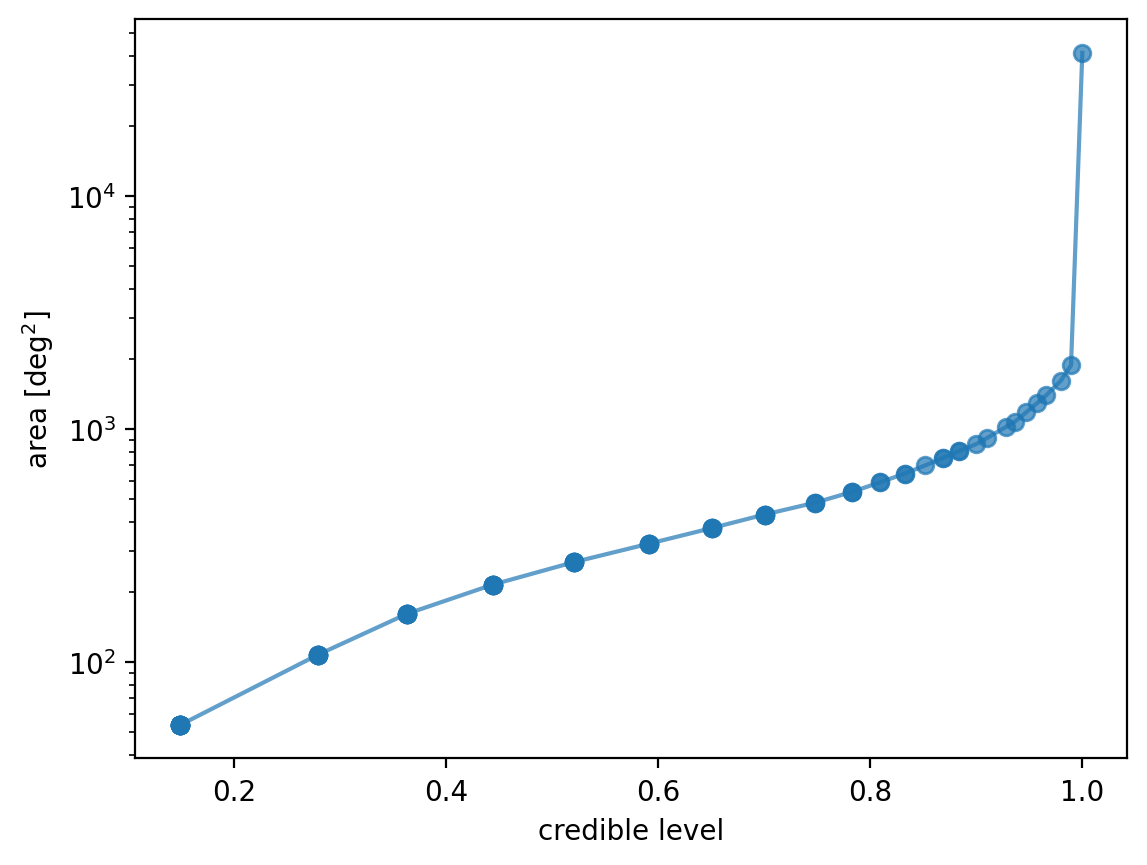

In [20]:
# plot the areas as a function of credible level

plt.plot(CL_true, CL_areas, marker='o', alpha=0.7)
plt.xlabel('credible level')
plt.ylabel('area [deg$^2$]')
plt.yscale('log')
plt.show()

### Skymap plotting with `ligo.skymap`

https://lscsoft.docs.ligo.org/ligo.skymap/index.html <br>
https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html#module-ligo.skymap.plot.allsky

Let's get a better visualization of this by looking at these different credible levels and areas on a skymap. Here we'll switch to `ligo.skymap` instead of `healpy` plotting $-$ it's the skymap plotting tool developed and used by LIGO, and it has a lot of cool functionalities we'll get practice with throughout the rest of the notebook!

First we'll plot the 90% credible area we calculated earlier.

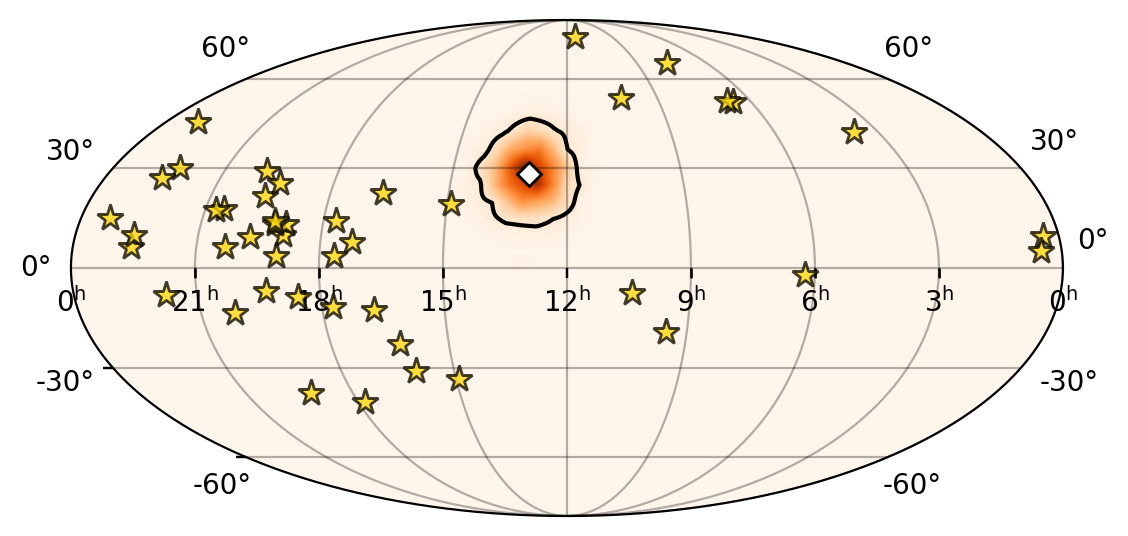

In [21]:
# this is the typical skymap projection and takes care of all coordinate transforms!
plt.figure()
ax = plt.axes(projection='astro hours mollweide') 

# this is our pixelated 2D histogram map
ax.imshow_hpx(norm_map, cmap='Oranges')

# need the line below to set the 90% contour level - finding the index of the true credible level
cut90 = np.argmax(credible_levels[w90])

# plot the 90% contour
ax.contour_hpx(norm_map, cmap=mpl.colors.ListedColormap(['k']), linewidths=1.5, levels=[norm_map[w90][cut90]])

# plot the pulsars in this simulated array
psr_ra = [p.phi*180/np.pi for p in ex_psrs]
psr_dec = [(np.pi/2-p.theta)*180/np.pi for p in ex_psrs]
ax.plot(psr_ra, psr_dec,
        marker='*', color='gold', markeredgecolor='k', ls='', alpha=0.75, ms=10, 
        transform=ax.get_transform('world'))

# plot the injected GW location
gw_ra = 15*(13 + 0/60 + 8.09/3600)
gw_dec = 27 + 58/60 + 37.2/3600
gwphi = gw_ra*np.pi/180
gwtheta = np.pi/2 - gw_dec*np.pi/180
ax.plot(gw_ra, gw_dec,
        marker='D', color='w', markeredgecolor='k', ls='', ms=6, 
        transform=ax.get_transform('world'))

# other plotting params
ax.grid(alpha=0.3, color='k')
plt.show()

This skymap is a noticeably a little smoothed out compared to the one we plotted with `healpy`, which is something `ligo.skymap` does internally. But now we've got a nice black contour boundary, which makes it really easy to see the area of the sky encompassed in the 90% credible region. **Use the space below to plot some other credible areas you found earlier.** Make sure you find the levels value needed for the `ax.contour_hpx` function.

Credible level: 0.44383300000000003
Area: 214.8591731740587 sq deg


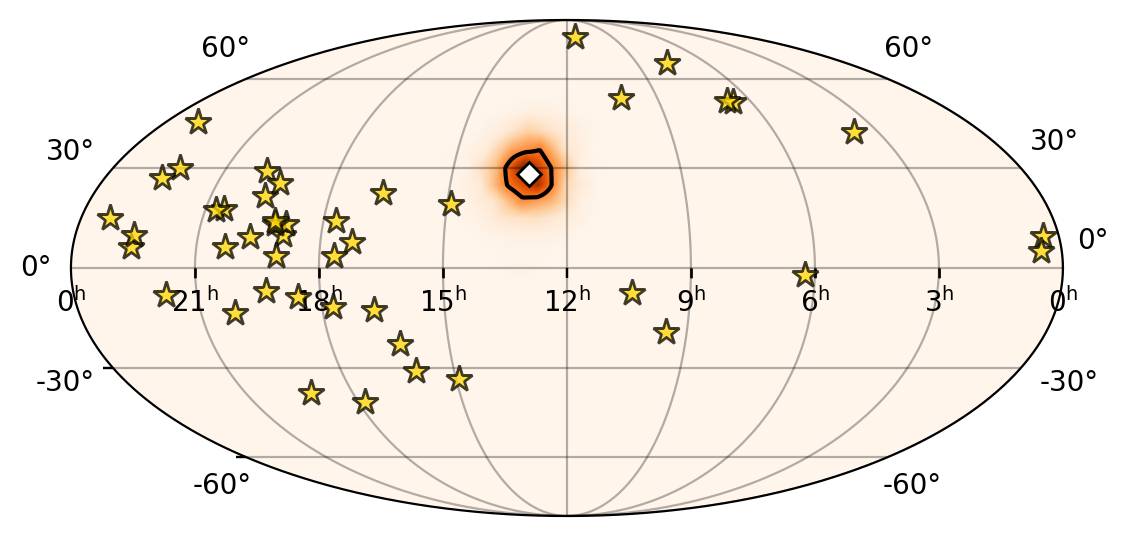

In [22]:
# space to plot other credible regions

# finding 50% credible region
w50 = np.where(credible_levels <= 0.5)[0]
true50 = max(credible_levels[w50])
print('Credible level:', true50)
area50 = np.sum(credible_levels <= 0.5) * hp.nside2pixarea(nside, degrees=True)
print('Area:', area50, 'sq deg')

# plotting 50% credible region
plt.figure()
ax = plt.axes(projection='astro hours mollweide') 
ax.imshow_hpx(norm_map, cmap='Oranges')
cut50 = np.argmax(credible_levels[w50])
ax.contour_hpx(norm_map, cmap=mpl.colors.ListedColormap(['k']), linewidths=1.5, levels=[norm_map[w50][cut50]])

# plot the pulsars in this simulated array
psr_ra = [p.phi*180/np.pi for p in ex_psrs]
psr_dec = [(np.pi/2-p.theta)*180/np.pi for p in ex_psrs]
ax.plot(psr_ra, psr_dec,
        marker='*', color='gold', markeredgecolor='k', ls='', alpha=0.75, ms=10, 
        transform=ax.get_transform('world'))

# plot the injected GW location
gw_ra = 15*(13 + 0/60 + 8.09/3600)
gw_dec = 27 + 58/60 + 37.2/3600
gwphi = gw_ra*np.pi/180
gwtheta = np.pi/2 - gw_dec*np.pi/180
ax.plot(gw_ra, gw_dec,
        marker='D', color='w', markeredgecolor='k', ls='', ms=6, 
        transform=ax.get_transform('world'))

# other plotting params
ax.grid(alpha=0.3, color='k')
plt.show()

# 3. Looking for host galaxies

Now that we've got the tools to do skymap plotting, let's dive into some of those multi-messenger questions we touched on earlier. The localization region we plotted spans an area of ~ 860 deg$^2$! That's a pretty large chunk of the sky that we need to search through to find the host galaxy of the SMBHB emitting the GW signal... how do we narrow down where the GW signal is coming from?

Identifying the correct host galaxy is still an open challenge when it comes to PTA multi-messenger studies. We heard in the morning session about a variety of possible EM signatures that SMBHBs may generate. Maybe we take a look into the systems lying within this localization region and check to see if any of them produce the kinds of EM signatures we think SMBHBs should make. But the **ambiguity in EM signatures** makes it difficult for us to be completely sure of what we're looking for! For example, we don't have sure-fire EM evidence of SMBHBs in the way that LIGO neutron star binaries do. And aside from that, the ~ 860 deg$^2$ area we saw above is not unusual for a PTA localization region. PTAs have pretty **poor localization capability** $-$ for the first GW signals that PTAs will localize, we expect to see areas on the order of ~ 100-1000 deg$^2$.

But just how many potential host galaxies lie in regions of this size? **Let's take a look using NANOGrav's catalog of massive galaxies in the local universe.** This catalog was assembled from the 2MASS Redshift Survey (done in infrared bands), and it contains sky coordinates, distances, and SMBH masses for 43,532 galaxies out to redshift z ∼ 0.05. The catalog is 97.6% complete to ∼ 300 Mpc and apparent $K$-band magnitudes $m_K$ ≤ 11.75, and it extends out to ∼ 500−700 Mpc for the most massive galaxies that will be prime targets for PTAs.

For more on the 2MASS Redshift Survey: https://arxiv.org/abs/1108.0669 <br>
For more on the NANOGrav galaxy catalog: https://arxiv.org/abs/2101.02716

### Galaxy catalog
**Run the cell below to read in the catalog and examine its contents.** A few important details:
<il>
- The galaxy name is given in the format (RA, dec) = (hhmmss.ss, +/- ddmmss.s) where h=hours, d=degrees, m=minutes, s=seconds.
- In some cases, there are two different estimates of the SMBH mass, which comes from the $M_{\rm{BH}} - M_{\rm{bulge}}$ relationship. One estimate uses the assumption $f_{\rm{bulge}}=1$ and the other uses $f_{\rm{bulge}}=0.31$.
- Uncertainty on the SMBH mass is given in $\rm{M}_\odot$.
- The distance and mass flags indicate the methods used to calculate these quantities.
</il>

In [23]:
# examine galaxy catalog's contents
with open(basedir+'gxy_catalog.txt') as f:
    contents = f.read()
    print(contents)

Title:The NANOGrav 11yr Data Set: Limits on Supermassive Black Hole Binaries in Galaxies within 500Mpc
Authors: Arzoumanian et al. Corresponding author: Maria Charisi [maria.charisi[at]nanograv.org]
Table: 2MRS galaxy catalog with estimates of the SMBH mass and distance, along with the GW strain upper limit towards the direction of each galaxy.
Byte-by-byte Description of file: datafile.txt
--------------------------------------------------------------------------------
   Bytes Format Units       Label            Explanations
--------------------------------------------------------------------------------
   1- 16 A16    ---         Name             Source Name
  17- 21 F5.2   Mpc         Dist             Galaxy Distance in Mpc
  22- 24 F3.2   [solMass]   BHMassfbulge1    SMBH mass assuming fbulge=1
  25- 27 F3.2   [solMass]   BHMassfbulge031  SMBH mass assuming fbulge=0.31
  28- 30 F3.2   [solMass] e_BHMassfbulge1    SMBH mass uncertainty
  31- 33 E3.2   ---         GWstrain         

In [24]:
# read in galaxy catalog
catalog = csv.reader(open(basedir+'gxy_catalog.txt'), delimiter="\t")
gxy_data = list(catalog)[20:-1]
gxy_data

[['00424433+4116074  0.82 8.15 8.15 0.17 4.22e-15 1 1'],
 ['00473313-2517196  3.81 7.74 7.74 0.45 3.76e-15 1 4'],
 ['09553318+6903549  3.87 7.90 7.90 0.08 5.51e-15 1 1'],
 ['13252775-4301073  3.92 7.77 7.77 0.08 3.31e-15 1 1'],
 ['13052727-4928044  3.99 7.22 7.22 0.43 3.28e-15 1 4'],
 ['01335090+3039357  0.97 6.23 6.23 0.44 5.56e-15 1 4'],
 ['09555243+6940469  3.78 8.17 8.17 0.43 5.51e-15 1 4'],
 ['03464851+6805459  3.63 7.21 7.21 0.46 6.01e-15 1 4'],
 ['13370091-2951567  4.99 7.64 7.64 0.45 2.69e-15 1 4'],
 ['12395949-1137230 10.95 8.83 8.83 0.03 3.49e-15 1 1'],
 ['00424182+4051546  0.84 6.41 6.41 0.08 4.22e-15 1 1'],
 ['12505314+4107125  4.92 6.83 6.83 0.10 3.66e-15 1 1'],
 ['12564369+2140575  5.68 6.20 6.20 0.11 3.14e-15 1 1'],
 ['20345233+6009132  4.30 6.94 6.94 0.43 3.38e-15 2 4'],
 ['12294679+0800014 17.22 9.38 9.38 0.04 3.66e-15 1 1'],
 ['13295269+4711429  9.19 6.46 6.46 0.43 3.63e-15 1 3'],
 ['12185761+4718133  7.83 7.56 7.56 0.00 3.78e-15 1 1'],
 ['03224178-3712295 18.71 8.23 

We now have the data separated into an array for each galaxy, but the different quantities for each galaxy are still given as strings. Let's make separate arrays for each column of the catalog.

In [25]:
# get columns for galaxy name (ID), distance, and BH mass (f_bulge=1)

IDs = []
dists = []
BHmasses = []
for line in gxy_data:
    new_line = line[0].split(' ')
    new_line = [x for x in new_line if len(x)>0]
    IDs.append(new_line[0])
    dists.append(float(new_line[1]))
    BHmasses.append(float(new_line[2]))

# turning these into numpy arrays will be more convenient later on
IDs = np.array(IDs)
dists = np.array(dists)
BHmasses = np.array(BHmasses)

### Host properties

Let's get some familiarity with these galaxies' properties. Since we've just done a ton of skymap plotting, let's plot these galaxies on a skymap!

In [ ]:
# let's use astropy to take care of the coordinate conversion - this might take a few seconds

gxy_ra = []
gxy_dec = []

for gxyID in IDs:
    
    # split up the string according to the RA and Dec
    ra = gxyID[0:2]+'h'+gxyID[2:4]+'m'+gxyID[4:6]+'.'+gxyID[6:8]+'s'
    dec = gxyID[8:11]+'d'+gxyID[11:13]+'m'+gxyID[13:15]+'.'+gxyID[15]+'s'
    
    # make a SkyCoord object using astropy
    # 'icrs' refers to the coordinate system/reference frame
    coord = SkyCoord(ra, dec, frame='icrs')
    
    # grab RA and Dec values in units of degrees
    gxy_ra.append(coord.ra.deg)
    gxy_dec.append(coord.dec.deg)

gxy_ra = np.array(gxy_ra)
gxy_dec = np.array(gxy_dec)

In [ ]:
# plot all galaxies on a skymap

plt.figure(figsize=(12,10))
ax = plt.axes(projection='astro hours mollweide')
ax.plot(gxy_ra, gxy_dec,
        marker='o', color='dodgerblue', markeredgecolor='k', ls='', alpha=0.5, ms=3,
        transform=ax.get_transform('world'))
ax.grid(alpha=0.3, color='k')
plt.show()

You'll notice there's an empty U-shaped band across the sky where we don't have many galaxies $-$ this is the plane of the Milky Way. It's difficult to see through our own galaxy out to the distances where other galaxies are, so the catalog doesn't really contain any galaxies in this region.

**Let's take a look now at the distribution of distances and BH masses.** Note: there are a few quasars in this catalog, which have negative BH masses to differentiate them from the other galaxies. Set the x-limit accordingly on your BH mass plot to remove them.

In [ ]:
# plot histogram of distances
plt.hist(dists, bins=50, histtype='step', lw=2)
#plt.hist(np.log10(dists), bins=50, histtype='step', lw=2)
plt.xlabel('galaxy distances')
plt.show()

In [ ]:
# plot histogram of BH masses
plt.hist(BHmasses, bins=50, histtype='step', lw=2)
plt.xlabel('log BH masses')
plt.xlim(4,11)
plt.show()

### How many potential hosts are we dealing with?

So exactly how many potential host galaxies lie in our 90% credible area of ~ 860 deg$^2$? We'll take a look using the plotting function below, which does much of what we went through above. The function takes as inputs an array of host galaxy RA and dec values, a normalized HEALPix skymap, and a credible level (set to the standard 90% by default). Then, as we did above, it generates a credible level map, calculates the true credible level, the localization area, and plots the area on a skymap. Saving the contour path, it will then count up how many hosts lie within the localization area using a handy `matplotlib` function and plot those on the map as well. There's also an option to plot a zoom-in panel alongside the skymap to see the localization region more clearly! **At the end, it will return a mask array with the same length as your host galaxy coordinate arrays, with 0 for those that fall within the localization region, and 1 for those that lie outside of the localization region.**

In [364]:
def plot_hosts(host_ra, host_dec, skymap, cl=0.9, zoom=False, second_mask=None):

    '''
    host_ra: array of host galaxy right ascension coordinates
    host_dec: array of host galaxy declination coordinates
    skymap: normalized healpix map
    cl: credible level
    
    '''

    # first makes a credible level map from the normalized map
    sort = np.flipud(np.argsort(skymap))
    sorted_credible_levels = np.cumsum(skymap[sort])
    credible_levels = np.empty_like(sorted_credible_levels)
    credible_levels[sort] = sorted_credible_levels

    # find the true credible level and area
    w_cl = np.where(credible_levels <= cl)[0]
    cut_cl = np.argmax(credible_levels[w_cl])
    true_cl = credible_levels[w_cl][cut_cl]
    print('Credible level:', true_cl)
    area = np.sum(credible_levels <= cl) * hp.nside2pixarea(nside, degrees=True)
    print('Area:', area, 'sq deg')

    # plotting credible region
    ax = plt.subplot(projection='astro hours mollweide')
    ax.imshow_hpx(skymap, cmap='Oranges', smooth=None)
    skyContour = ax.contour_hpx(skymap, cmap=mpl.colors.ListedColormap(['k']), levels=[skymap[w_cl][cut_cl]])

    # need to transform RA, dec of host galaxies to the axis coordinates
    transform_obj = ax.get_transform('world') + ax.transData.inverted()
    gxy_pos = np.stack([host_ra, host_dec], axis=1)
    gxy_pos_transform = transform_obj.transform(gxy_pos)

    # using the boundary of the contour to find the number of galaxies within the credible region
    # start with an array of 1's --> this means all galaxies will be masked out, i.e., not visible on the map
    mask = np.ones(len(host_ra), dtype=bool)
    
    # for each contour path and each galaxy, check if the galaxy lies within the contour
    for path in skyContour.collections[0].get_paths():
        for j in range(len(mask)):
            # if galaxy is inside path, unmask it (set mask=0 for that galaxy)
            if path.contains_point(gxy_pos_transform[j]):
                #if MBH_fbulge1[j] > 0.0: #only keep galaxy if not negative mass (quasar)
                mask[j] = 0

    # which galaxies are inside the contour?
    w_in = np.where(mask == 0)[0]
    print('Galaxies in region:', len(w_in))

    # plot galaxies in localization region
    ax.plot(np.ma.masked_array(gxy_pos_transform[:,0], mask=mask),
            np.ma.masked_array(gxy_pos_transform[:,1], mask=mask),
            color='turquoise', markeredgecolor='k', marker='o',
            ls='', alpha=0.7, ms=3)

    # plot galaxies passing distance cut
    if second_mask is not None:
        ax.plot(np.ma.masked_array(gxy_pos_transform[:,0], mask=second_mask),
                np.ma.masked_array(gxy_pos_transform[:,1], mask=second_mask),
                color='gold', markeredgecolor='k', marker='o',
                ls='', alpha=0.7, ms=3)

    # zoom-in plotting
    if zoom:
        
        max_ra = max(host_ra[w_in])
        min_ra = min(host_ra[w_in])
        max_dec = max(host_dec[w_in])
        min_dec = min(host_dec[w_in])
        
        rad = str(max([max_ra-min_ra, max_dec-min_dec])-10) + ' deg'
        center = str((max_ra+min_ra)/2) + 'd ' + str((max_dec+min_dec)/2) + 'd'

        ax_zoom_rect = plt.axes([1.0, 0.3, 0.4, 0.4],
                                projection='astro degrees zoom',
                                center=center,
                                radius=rad)
        ax_zoom_rect.imshow_hpx(skymap, cmap='Oranges', smooth=None)
        zoomContour = ax_zoom_rect.contour_hpx(skymap, cmap=mpl.colors.ListedColormap(['k']), linewidths=1.5,
                                               levels=[skymap[w_cl][cut_cl]])
        ax_zoom_rect.set_xlabel(' ')
        ax_zoom_rect.set_ylabel(' ')
        
        tzoom_obj = ax_zoom_rect.get_transform('world') + ax_zoom_rect.transData.inverted()
        gxy_pos_tzoom = tzoom_obj.transform(gxy_pos)
        mask_zoom = np.ones(43532, dtype=bool)
        for path in zoomContour.collections[0].get_paths():
            for j in range(len(mask_zoom)):
                if path.contains_point(gxy_pos_tzoom[j]):
                    mask_zoom[j] = 0

        ax_zoom_rect.plot(np.ma.masked_array(gxy_pos_tzoom[:,0], mask=mask_zoom),
                          np.ma.masked_array(gxy_pos_tzoom[:,1], mask=mask_zoom),
                          color='turquoise', markeredgecolor='k', marker='o',
                          ls='', alpha=0.7, ms=3)

        if second_mask is not None:
            ax_zoom_rect.plot(np.ma.masked_array(gxy_pos_tzoom[:,0], mask=second_mask),
                              np.ma.masked_array(gxy_pos_tzoom[:,1], mask=second_mask),
                              color='gold', markeredgecolor='k', marker='o',
                              ls='', alpha=0.7, ms=3)

        ax_zoom_rect.grid(alpha=0.3, color='k')
        ax_zoom_rect.tick_params(axis='both', which='major')

        ax.mark_inset_axes(ax_zoom_rect)
        ax.connect_inset_axes(ax_zoom_rect, 'upper right')
        ax.connect_inset_axes(ax_zoom_rect, 'lower right')
    
    # other plotting params
    ax.grid(alpha=0.3, color='k')
    ax.tick_params(axis='both', which='major')
    plt.show()

    return mask

Credible level: 0.899295
Area: 859.4366926962348 sq deg


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in skyContour.collections[0].get_paths():


Galaxies in region: 1371


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in zoomContour.collections[0].get_paths():


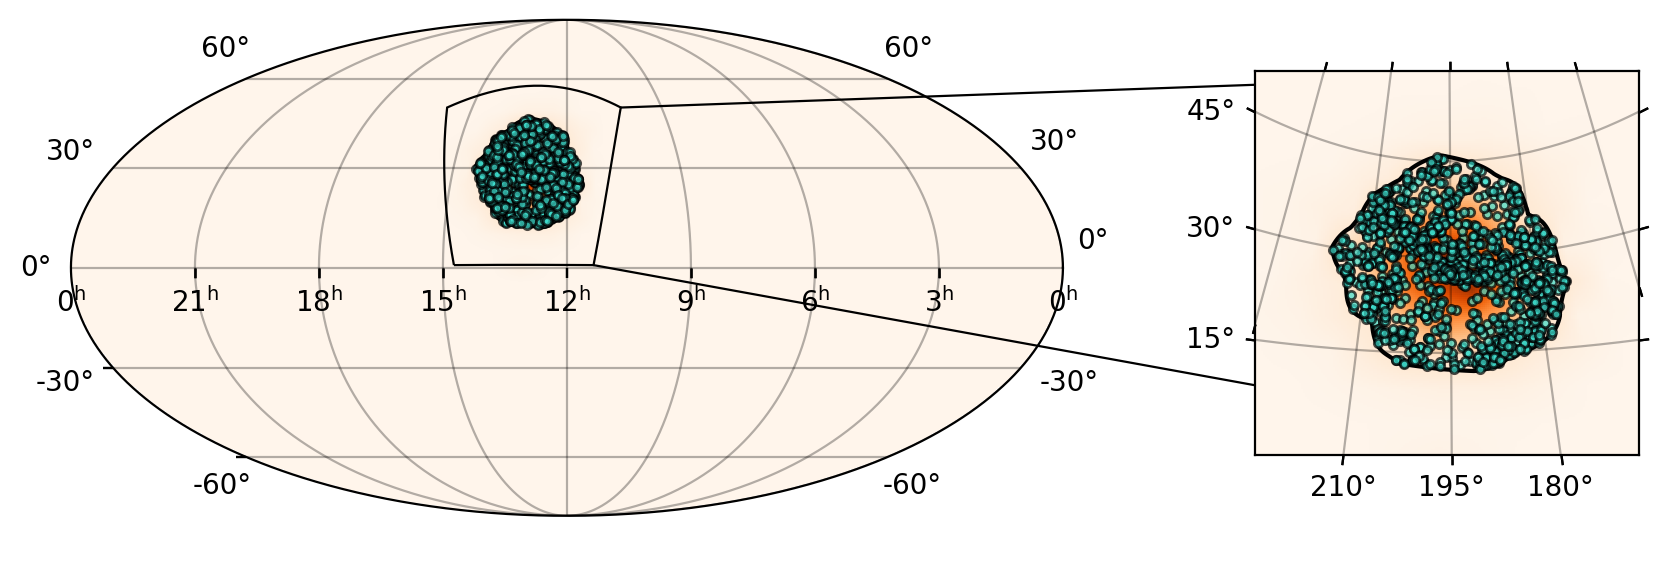

In [365]:
sky_mask = plot_hosts(gxy_ra, gxy_dec, norm_map, cl=0.9, zoom=True)

So we've eliminated 42,161 galaxies (~97%) so far by looking only at those that lie in our localization area. But don't be fooled by percentages $-$ 1371 is still a large number of galaxies to sift through! Maybe we can use some other host properties we can use to discard more potential hosts...

# 5. Process of host elimination

***WARNING: You are now entering exploratory territory.*** How do we find the true host galaxy, or at least narrow down the number of potential host galaxies, starting from 1000+ candidates? This question is in the process of being explored, but it's a very important one to answer if we want to achieve a coordinated multi-messenger detection of a SMBHB system! In this section, we'll just begin to scratch the surface when it comes to figuring out how to cut out more hosts.

As is, our galaxy catalog contains **distance** and **SMBH mass** estimates for each of our galaxies. For now, let's use these two pieces of information to see if we can do better to eliminate additional host candidates.

### Implementing a distance cut
One of the simplest things we can do is to look at the entire three-dimensional localization **volume** as opposed to just the localization area on the sky. To do this, we'll need to convert our posterior samples on the GW frequency, strain, and chirp mass to posterior samples on the luminosity distance. We can do this by rearranging the following equation:

$$
\begin{equation}
h_{0} = \frac{2 \mathcal{M}^{5/3}(\pi f_{\rm{GW}})^{2/3}}{d_{L}}
\end{equation}
$$

In [366]:
# grab the relevant samples from our chain
fgw_samples = 10**chain[burn:,3]
h_samples = 10**chain[burn:,4]
mc_samples = 10**chain[burn:,5]

In [367]:
# convert into samples on the luminosity distance
# we'll use log-distance samples going forward, since we log-sampled in frequency, strain, and chirp mass
dist_samples = (2 * (mc_samples*const.Tsun)**(5/3) * (np.pi * fgw_samples)**(2/3) / h_samples) / const.Mpc * const.c
logdist_samples = np.log10(dist_samples)

For the simple distance cut we'll do here, we're just going to choose one or two cutoff values based on our luminosity distance posterior. To be a little conservative, let's take the 95% credible interval (where 95% of the posterior samples fall in the distribution) and cut out any galaxies that have distances lying beyond the edges of this interval. To visualize this, run the next couple cells.

In [368]:
# for the 95% credible interval, we need to find the distance values corresponding to the 50 +/- (95/2) percentiles
perc_cuts = [2.5, 97.5]
cutoffs = [np.percentile(logdist_samples, q=perc) for perc in perc_cuts]

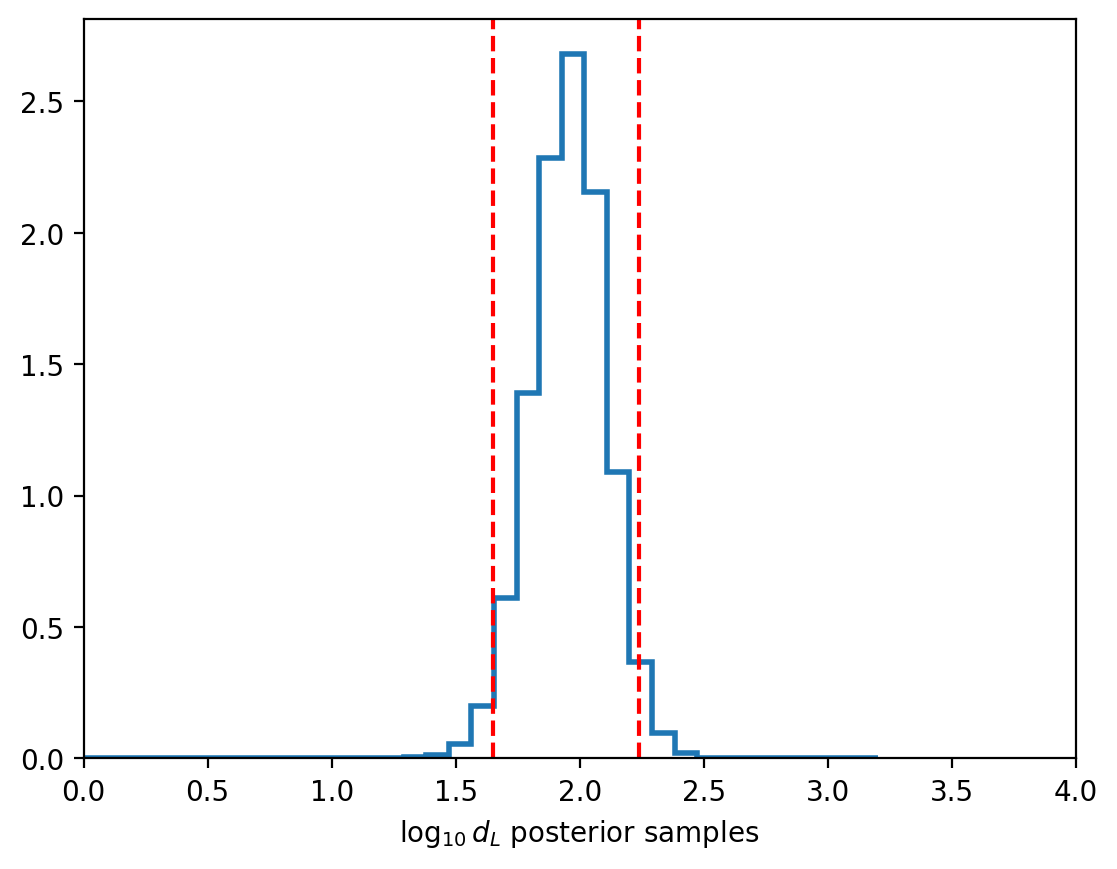

In [369]:
# plot the luminosity distance posterior distribution
plt.hist(logdist_samples, bins=50, histtype='step', lw=2, density=True)

# plot the cutoff values for comparison
for cut in cutoffs:
    plt.axvline(cut, ls='--', color='r')

plt.xlabel('$\log_{10}d_L$ posterior samples')
plt.xlim(0,4)
plt.show()

Now use the `dist_cut` function below to perform the cut and see how many galaxies remain afterwards. We'll need a list of galaxy distances (for ALL galaxies in the catalog), the luminosity distance posterior samples, our cutoff values, and our sky mask that we made earlier. The function will then make a new mask that will mask out galaxies now according to **two criteria**: whether or not it lies in the localization area, and whether or not it falls within the distance cut boundaries.

In [370]:
def dist_cut(gxy_dists, logd_samples, cutoffs, mask):
    
    '''
    gxy_dists: array of host galaxy distances
    logd_samples: log luminosity distance posterior samples
    cutoffs: value(s) with which to perform distance cut(s). can be one or two values. if two, should be in ascending order.
    mask: mask of galaxies lying within localization area (0=included, 1=excluded)
    '''

    # make copy of sky mask for new distance mask
    dmask = np.copy(mask)
    
    # if using 2 cuts
    if len(cutoffs) > 1:
        # for each galaxy, first check if the galaxy is not already masked out
        for i,d in enumerate(np.log10(gxy_dists)):
            if dmask[i] != 1:
                # mask out the galaxy if it lies outside the boundaries
                if d < cutoffs[0] or d > cutoffs[1]:
                    dmask[i] = 1

    # if using 1 cut
    else:
        # check whether cutoff value is below or above the median to determine the type of cut (lower/upper)
        p50 = np.percentile(logd_samples, q=50)
        print(p50)

        # lower cut
        if cutoffs[0] < p50:
            # for each galaxy, first check if the galaxy is not already masked out
            for i,d in enumerate(np.log10(gxy_dists)):
                if dmask[i] != 1:
                    # mask out the galaxy if it lies below the boundary
                    if d < cutoffs[0]:
                        dmask[i] = 1
            
        # upper cut
        else:
            # for each galaxy, first check if the galaxy is not already masked out
            print(len(np.where(dmask==0)[0]))
            for i,d in enumerate(np.log10(gxy_dists)):
                if dmask[i] != 1:
                    # mask out the galaxy if it lies above the boundary
                    if d > cutoffs[0]:
                        dmask[i] = 1

    return dmask

In [371]:
# make a sky + distance mask
sky_dist_mask = dist_cut(dists, logdist_samples, cutoffs, sky_mask)

# find which galaxies are not masked out and count them
w_in_d = np.where(sky_dist_mask == 0)[0]
print('Galaxies remaining after distance cut:', len(w_in_d))

Galaxies remaining after distance cut: 1037


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2224989821.py:16: RuntimeWarning: invalid value encountered in log10
  for i,d in enumerate(np.log10(gxy_dists)):


Let's visualize this. We can replot our skymap with all the galaxies in the localization area in turquoise, and those that pass the distance cut in gold. To do this, supply the `second_mask` argument in the `plot_hosts` function with the sky + distance mask.

Credible level: 0.899295
Area: 859.4366926962348 sq deg


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in skyContour.collections[0].get_paths():


Galaxies in region: 1371


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in zoomContour.collections[0].get_paths():


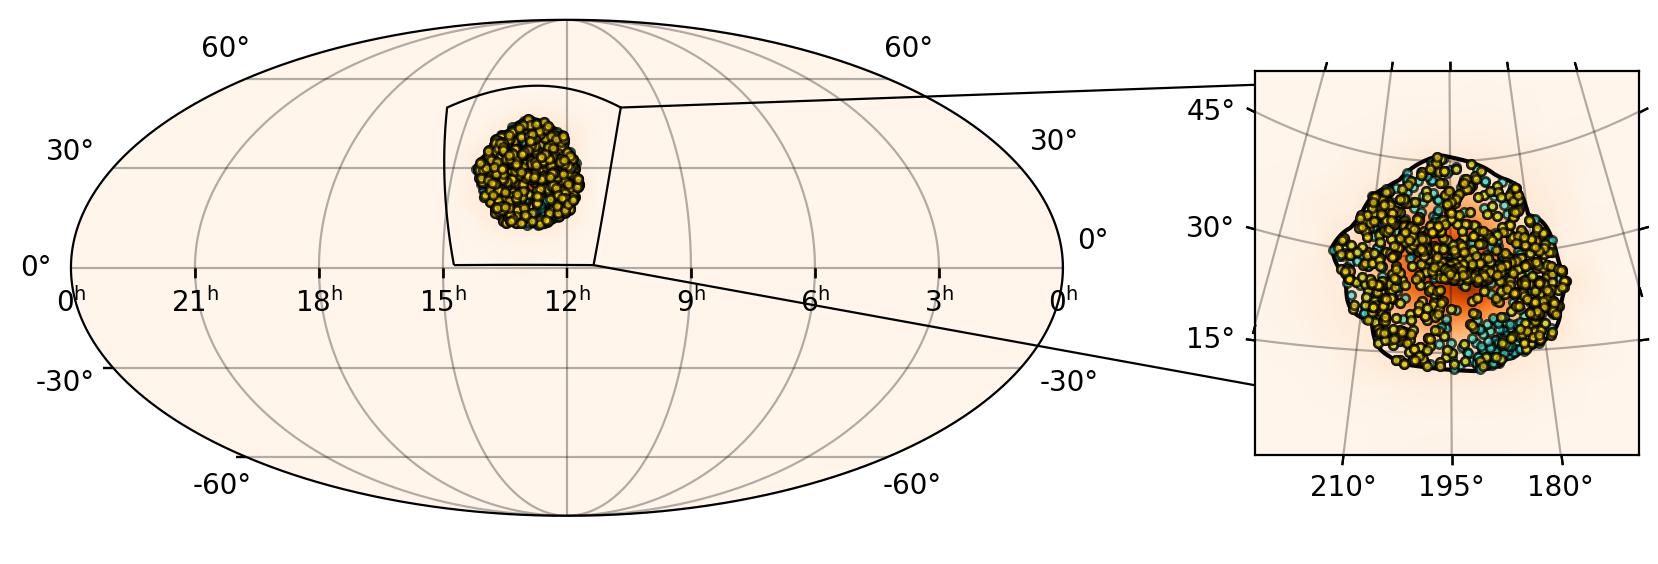

In [372]:
# plot with distance mask added on top
_ = plot_hosts(gxy_ra, gxy_dec, norm_map, cl=0.9, zoom=True, second_mask=sky_dist_mask)

So a 95% credible interval distance cut helps us a little bit. In this case, we went from 1371 potential hosts down to 1037 potential hosts, cutting out ~300 galaxies.

**Let's go back and try some different cutoff values**, i.e., change the values in the `perc_cuts` array. What happens if you set your boundaries closer and closer to the peak of the luminosity distance posterior distribution? e.g., Change this to a **68% credible interval cut (about ~1$\sigma$), or a 50% credible interval cut**, and see how many galaxies you're left with. **What about a single-value cut, only the lower 10%? Upper 10%?** Try any other values you're interested in investigating!

### Implementing a SMBH mass cut

The other piece of information we have in the galaxy catalog is a SMBH mass estimate $-$ we can assume that this is the total binary mass, i.e., assume that the galaxy contains a binary, and the quoted SMBH mass is the mass of both SMBHs combined. However, when analyzing the PTA data, we sample over the chirp mass of the binary, which is related to the total mass by the following relation: $\mathcal{M} = q^{3/5}/(1+q)^{6/5}M_{\mathrm{tot}}$

with $\mathcal{M}$ being the chirp mass and $M_{\mathrm{tot}}$ being the total binary mass taken from the galaxy catalog. The $q$ in this equation represents the mass ratio of the binary, which we unfortunately don't have any information about from our GW search. So we have a few options in terms of converting our chirp mass posterior samples into total mass samples:
<il>
- Make a reasonable assumption about the mass ratio. We expect PTA sources to mostly come from major mergers, i.e., $q \geq 0.25$.
- Draw from a distribution of mass ratio values. For example, between $0.25 \leq q \leq 1$, or if we want to be more conservative, between $0.1 \leq q \leq 1$.
- Use rejection sampling to decompose our chirp mass samples into samples on the mass ratio and total binary mass.
</il>

We'll go with option 1 for now, and just assume an equal-mass binary in each case, i.e., $q = 1$.

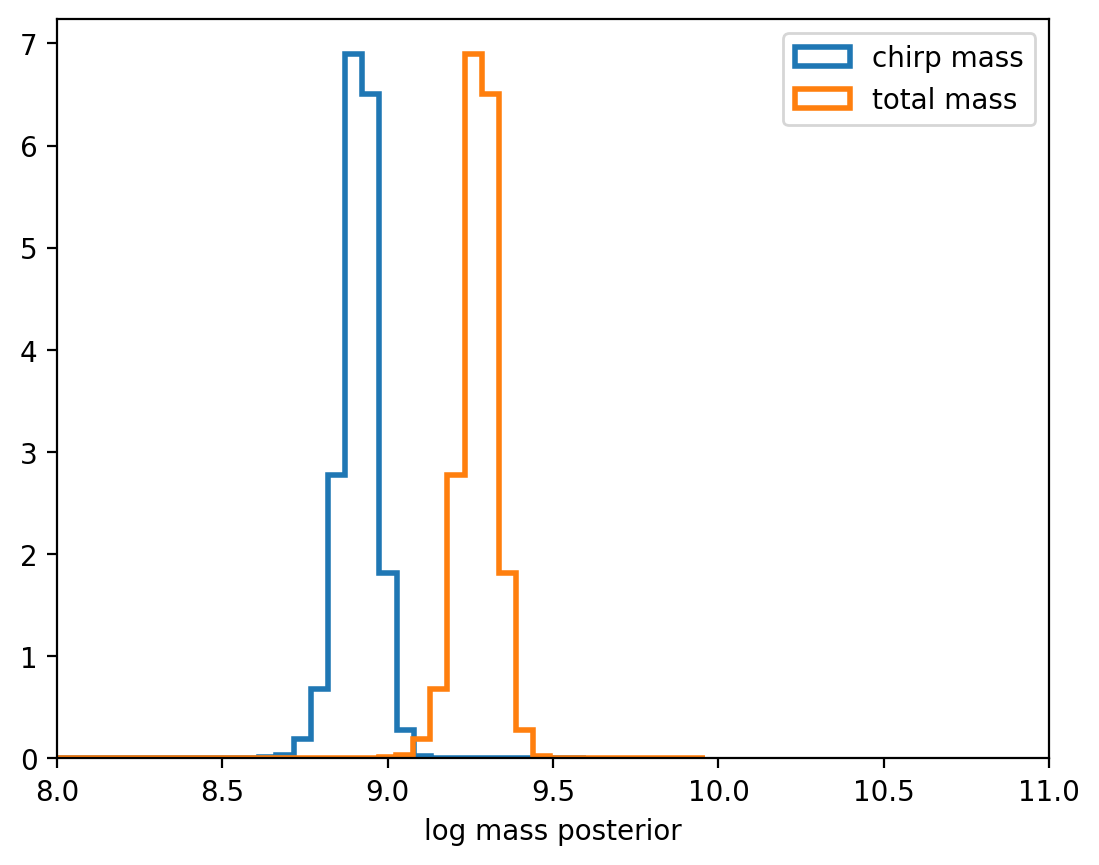

In [395]:
# convert chirp mass samples to total mass samples
q = 1.
mtot_samples = mc_samples / (q**(3/5) / (1+q)**(6/5))

# plot histogram of total mass samples
plt.hist(np.log10(mc_samples), bins=50, histtype='step', lw=2, label='chirp mass', density=True)
plt.hist(np.log10(mtot_samples), bins=50, histtype='step', lw=2, label='total mass', density=True)
plt.xlabel('log mass posterior')
plt.xlim(8,11)
plt.legend()
plt.show()

**Let's implement a similar kind of cut here and compare how well we do with our results from the distance cut.** The function below is exactly like the distance cut function, instead taking the galaxies' SMBH mass estimates, the total binary mass posterior samples, and new cutoff values. **How well can you do with a 95% credible interval cut?**

In [396]:
def MBH_cut(gxy_MBHs, logmtot_samples, cutoffs, mask):
    
    '''
    gxy_MBHs: array of host galaxy SMBH mass estimates
    logmtot_samples: log total binary mass posterior samples
    cutoffs: value(s) with which to perform distance cut(s). can be one or two values. if two, should be in ascending order.
    mask: mask of galaxies lying within localization area (0=included, 1=excluded)
    '''

    # make copy of sky mask for new distance mask
    mmask = np.copy(mask)
    
    # if using 2 cuts
    if len(cutoffs) > 1:
        # for each galaxy, first check if the galaxy is not already masked out
        for i,m in enumerate(gxy_MBHs):
            if mmask[i] != 1:
                # mask out the galaxy if it lies outside the boundaries
                if m < cutoffs[0] or m > cutoffs[1]:
                    mmask[i] = 1

    # if using 1 cut
    else:
        # check whether cutoff value is below or above the median to determine the type of cut (lower/upper)
        p50 = np.percentile(logmtot_samples, q=50)
        print(p50)

        # lower cut
        if cutoffs[0] < p50:
            # for each galaxy, first check if the galaxy is not already masked out
            for i,d in enumerate(gxy_MBHs):
                if mmask[i] != 1:
                    # mask out the galaxy if it lies below the boundary
                    if m < cutoffs[0]:
                        mmask[i] = 1
            
        # upper cut
        else:
            # for each galaxy, first check if the galaxy is not already masked out
            print(len(np.where(mmask==0)[0]))
            for i,d in enumerate(gxy_MBHs):
                if mmask[i] != 1:
                    # mask out the galaxy if it lies above the boundary
                    if m > cutoffs[0]:
                        mmask[i] = 1

    return mmask

In [397]:
# choose your cuts
perc_cuts = [2.5, 97.5]
m_cutoffs = [np.percentile(np.log10(mtot_samples), q=perc) for perc in perc_cuts]

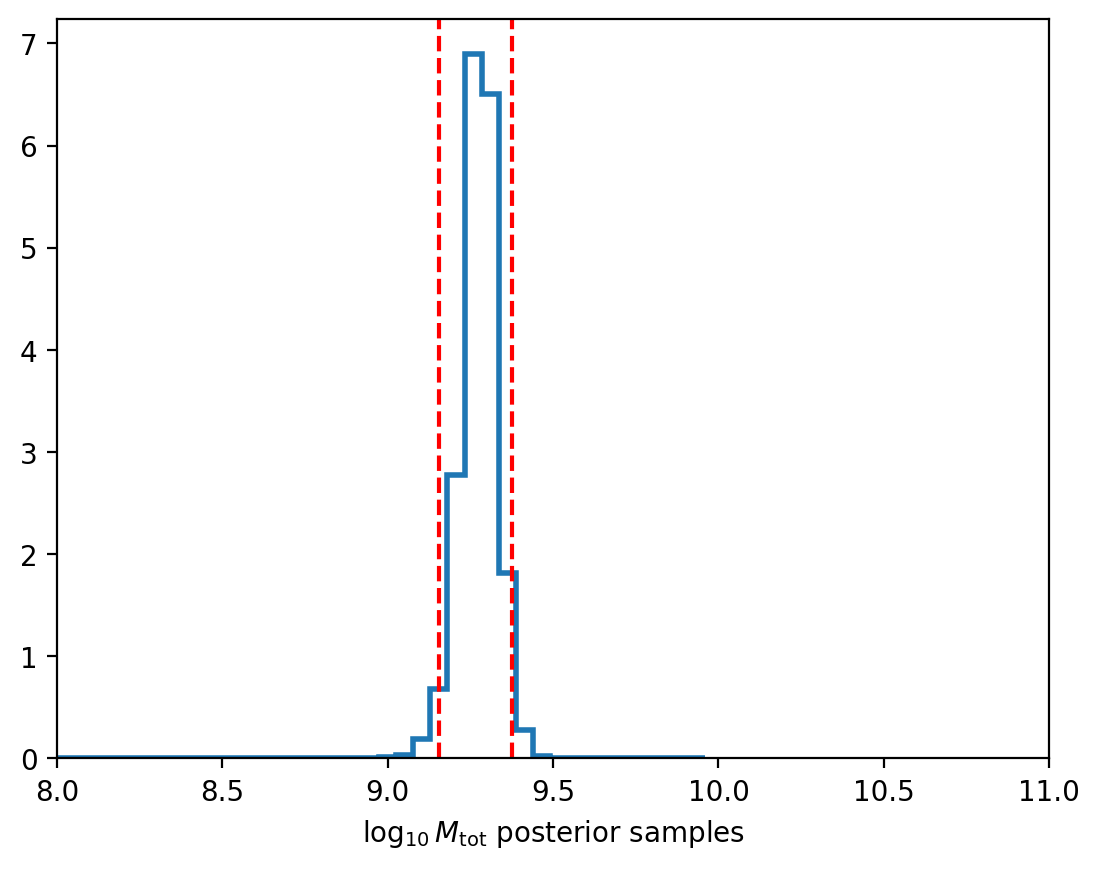

In [398]:
# plot the total binary mass posterior distribution with the cutoffs
plt.hist(np.log10(mtot_samples), bins=50, histtype='step', lw=2, density=True)

# plot the cutoff values for comparison
for cut in m_cutoffs:
    plt.axvline(cut, ls='--', color='r')

plt.xlabel(r'$\log_{10}M_{\rm{tot}}$ posterior samples')
plt.xlim(8,11)
plt.show()

In [399]:
# make a sky + BH mass mask
sky_MBH_mask = MBH_cut(BHmasses, np.log10(mtot_samples), m_cutoffs, sky_mask)

# find which galaxies are not masked out and count them
w_in_m = np.where(sky_MBH_mask == 0)[0]
print('Galaxies remaining after BH mass cut:', len(w_in_m))

Galaxies remaining after BH mass cut: 78


Credible level: 0.899295
Area: 859.4366926962348 sq deg


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in skyContour.collections[0].get_paths():


Galaxies in region: 1371


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/2708048812.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in zoomContour.collections[0].get_paths():


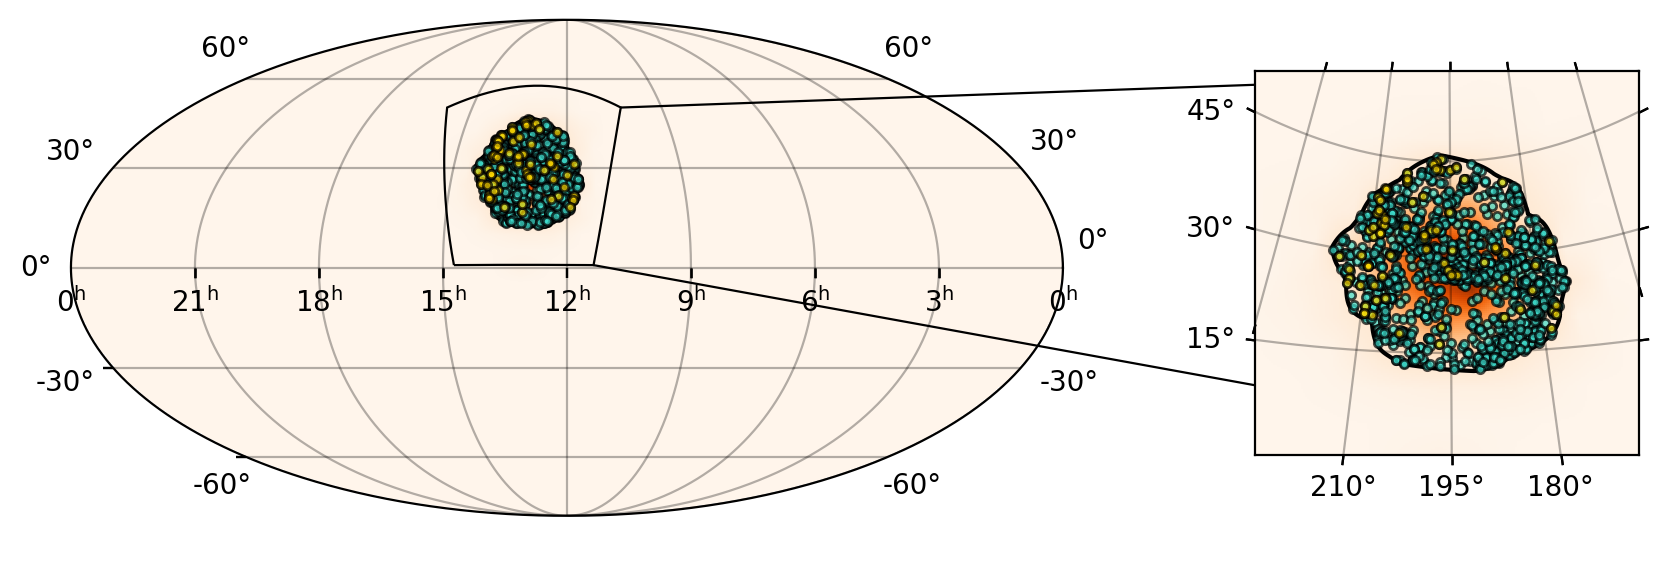

In [400]:
# plot with BH mass mask added on top
_ = plot_hosts(gxy_ra, gxy_dec, norm_map, cl=0.9, zoom=True, second_mask=sky_MBH_mask)

**Did your BH mass cut perform better than the distance cut? Can your BH mass cut do even better with more stringent cutoff values?**

### True galaxy check

Narrowing down the number of hosts is a crucial task, but we need to be careful, as we don't want to cut out the true galaxy hosting the SMBHB that made our GW signal by mistake! In the section below, I'll give you the galaxy ID for the true galaxy into which the CW signal was injected. **Use your sky+distance mask and your sky+mass mask to check if the true galaxy is among those remaining after your cuts. Is the true galaxy among those remaining after your distance cut? How about your mass cut?**

In [405]:
# sky coordinates for the true galaxy
true_ID = '13000809+2758372'

In [407]:
# check galaxies remaining after distance cut
w_in_d = np.where(sky_dist_mask == 0)[0]
if true_ID in IDs[w_in_d]:
    print('True galaxy remaining!')
else:
    print('True galaxy cut.')

True galaxy remaining!


In [408]:
# check galaxies remaining after BH mass cut
w_in_m = np.where(sky_MBH_mask == 0)[0]
if true_ID in IDs[w_in_m]:
    print('True galaxy remaining!')
else:
    print('True galaxy cut.')

True galaxy cut.


# Bonus material!

### Different BH mass cuts

Use the space below to try out different forms of BH mass cuts mentioned earlier. Some ideas:
<il>
- Maybe assuming equal-mass binaries with mass ratios of $q=1$ is a little idealistic... try using different mass ratio assumptions.
- For each chirp mass posterior sample, draw a $q$ value from a distribution, e.g., use values corresponding to major mergers. Calculate the corresponding total mass and create your total mass distribution that way.
- Try a different type of cut entirely! For each BH mass estimate in our galaxy catalog, we have uncertainties on the BH masses as well. You can assume a normal distribution for each galaxy's BH mass, and then calculate the overlap between this distribution and the total mass posterior.
</il>

**Minor hint:** The injected CW signal had a mass ratio of $q=0.005$. In reality, though, we don't expect to see binaries with such low mass ratios... this signal was just for a test run and wasn't meant to be completely realistic. But using that information, try your BH mass cut again!

In [ ]:
# space for BH mass cut exploration



### Combo distance + BH mass cut

**Note:** if you altered the way the total binary mass posterior was calculated, you may need to change the x-limits in the plot below.

/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/3096405856.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(BHmasses, np.log10(dists), marker='.', color='w', alpha=0.1, s=3)


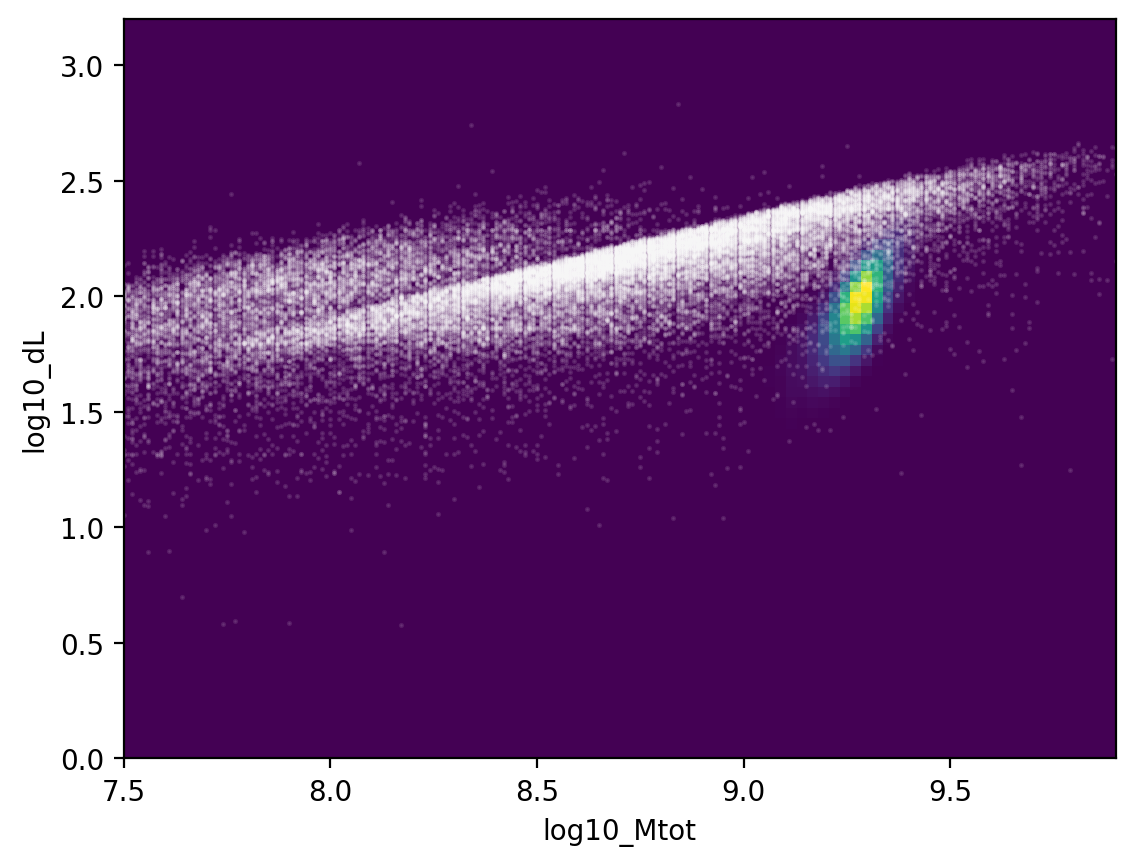

In [436]:
# plot both posteriors and all galaxies
plt.hist2d(np.log10(mtot_samples), logdist_samples, bins=100)
plt.scatter(BHmasses, np.log10(dists), marker='.', color='w', alpha=0.1, s=3)
plt.xlabel('log10_Mtot')
plt.ylabel('log10_dL')
plt.xlim(7.5,9.9)
plt.ylim(0,3.2)
plt.show()

In [ ]:
# space for dist + BH mass cut exploration



### Cuts with original galaxy data

If you're feeling brave, you can also revisit the original survey data from which our galaxy catalog was made, i.e., the 2MASS Redshift Survey data. **Check out the README file in the 2MRS directory of this repo to see what kind of data we have for each galaxy.** Things that might be helpful for host galaxy identification, for example, include magnitudes in different infrared bands ($K$-, $H$-, and $J$-band magnitudes) and morphological classifications. The galaxy IDs will be the same as those in the catalog we've worked with so far.

In [220]:
from astropy.io import fits

In [221]:
# read in survey file
survey_file = basedir+'/2MRS/2mrs_1175_done.fits'
survey_data = fits.open(survey_file)[1].data

In [409]:
# grab some important values
ID = []
K_tc = []
e_Kt = []
ext_BV = []
types = []
for i in range(0,len(survey_data)-1):
    ID.append(survey_data[i][0])
    K_tc.append(survey_data[i][8])
    e_Kt.append(survey_data[i][14])
    ext_BV.append(survey_data[i][17])
    types.append(survey_data[i][22])

In [437]:
# absolute K-band magnitude calculations
R_V = 3.1 #reddening relation
K_abs = []
for i in range(0,len(K_tc)):
    m_K = K_tc[i]
    E_BV = ext_BV[i]
    A_V = R_V*E_BV #A_V is extragalactic extinction
    M_K = m_K-5*np.log10(dists[i])-25-0.11*A_V
    K_abs.append(M_K)

/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_6507/3598288120.py:8: RuntimeWarning: invalid value encountered in log10
  M_K = m_K-5*np.log10(dists[i])-25-0.11*A_V


In [438]:
# total stellar mass of the galaxy
M_stel = [10**(10.58-0.44*(abs_mag+23)) for abs_mag in K_abs]

In [439]:
# space to explore other cuts

